#### Import libraries

In [212]:
import pandas as pd
import datetime as dt

#### Load data

In [213]:
df = pd.read_csv('./data/data.csv')

#### Clean data

In [214]:
# Convert object columns to numeric
df['land_size_sqm'] = pd.to_numeric(df['land_size_sqm'].str.replace(' sqm', ''))
df['house_size_sqm'] = pd.to_numeric(df['house_size_sqm'].str.replace(' sqm', ''))
df['distance_to_school'] = pd.to_numeric(df['distance_to_school'].str.replace('km', ''))
df['distance_to_supermarket'] = pd.to_numeric(df['distance_to_supermarket'].str.replace(' km', ''))
df['house_age'] = pd.to_numeric(df['house_age'].str.replace(' Years', ''))

# Convert Yes/No columns to 1/0
df['large_living_room'] = pd.to_numeric(df['large_living_room'].replace({'No': '0', 'Yes': '1'}))
df['parking_space'] = pd.to_numeric(df['parking_space'].replace({'No': '0', 'Yes': '1'}))
df['front_garden'] = pd.to_numeric(df['front_garden'].replace({'No': '0', 'Yes': '1'}))
df['swimming_pool'] = pd.to_numeric(df['swimming_pool'].replace({'No': '0', 'Yes': '1'}))
df['wall_fence'] = pd.to_numeric(df['wall_fence'].replace({'No': '0', 'Yes': '1'}))
df['water_front'] = pd.to_numeric(df['water_front'].replace({'No': '0', 'Yes': '1'}))
df['room_size'] = pd.to_numeric(df['room_size'].replace({'small': '0', 'medium': '1', 'large': '2', 'extra_large': '3'}))

# Create construction year column
#df['construction_year'] = dt.date.today().year - df['house_age']

# Delete house age column
#del df['house_age']


#### Exploratory Data Analysis

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

<Axes: xlabel='property_value', ylabel='Count'>

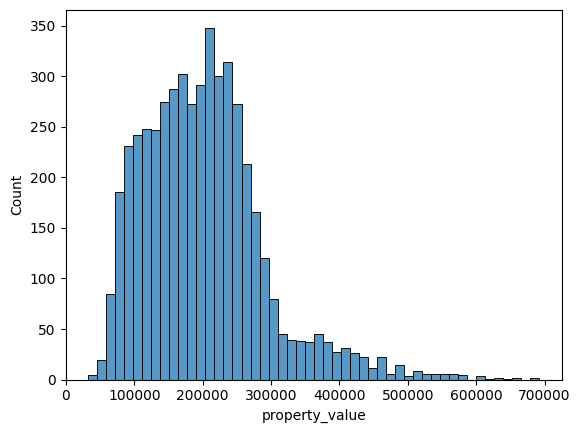

In [216]:
# Plot house prices. We can see there is a long tail effect.
sns.histplot(df.property_value, bins=50)

In [217]:
# Remove long tail by applying log+1 to house price
price_log = np.log1p(df.property_value)

<Axes: xlabel='property_value', ylabel='Count'>

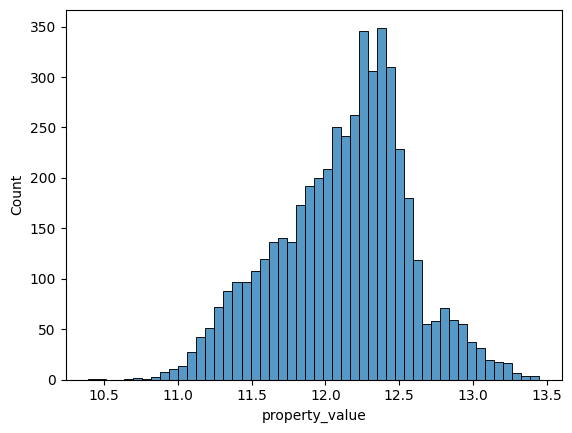

In [218]:
# Plot log+1 house prices
sns.histplot(price_log, bins=50)

In [219]:
# Check for missing values. We don't have any missing values.
df.isnull().sum()

land_size_sqm              0
house_size_sqm             0
no_of_rooms                0
no_of_bathrooms            0
large_living_room          0
parking_space              0
front_garden               0
swimming_pool              0
distance_to_school         0
wall_fence                 0
house_age                  0
water_front                0
distance_to_supermarket    0
crime_rate_index           0
room_size                  0
property_value             0
dtype: int64

#### Validation framework

In [220]:
# We split our dataset into train (60%), val (20%) and test (20%) datasets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [221]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [222]:
# Get target variable from the train, val, test datasets
y_train = np.log1p(df_train['property_value'].values)
y_val = np.log1p(df_val['property_value'].values)
y_test = np.log1p(df_test['property_value'].values)

In [223]:
# Delete the target variable from the datasets
del df_train['property_value']
del df_val['property_value']
del df_test['property_value']

#### Feature importance

In [224]:
from sklearn.metrics import mutual_info_score

In [225]:
mi_scores = []

features = df_full_train.columns

for f in features:
    mi_score = mutual_info_score(df_full_train.property_value, df_full_train[f])
    mi_scores.append({'f': f, 's': mi_score})


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [226]:
def sort_list(e):
    return e['s']

mi_scores.sort(reverse=True, key=sort_list)
    

In [227]:
mi_scores

[{'f': 'property_value', 's': np.float64(8.274130280049539)},
 {'f': 'crime_rate_index', 's': np.float64(6.307303354971627)},
 {'f': 'land_size_sqm', 's': np.float64(5.749057605473132)},
 {'f': 'house_size_sqm', 's': np.float64(5.698391887044677)},
 {'f': 'distance_to_school', 's': np.float64(4.126474549105726)},
 {'f': 'distance_to_supermarket', 's': np.float64(4.123743652749198)},
 {'f': 'house_age', 's': np.float64(3.079158172141659)},
 {'f': 'no_of_rooms', 's': np.float64(1.8163983365952991)},
 {'f': 'no_of_bathrooms', 's': np.float64(1.7880081113999897)},
 {'f': 'room_size', 's': np.float64(1.301524649359457)},
 {'f': 'swimming_pool', 's': np.float64(0.6597417925970321)},
 {'f': 'front_garden', 's': np.float64(0.6552260409553051)},
 {'f': 'wall_fence', 's': np.float64(0.654604735625357)},
 {'f': 'large_living_room', 's': np.float64(0.5819151449609423)},
 {'f': 'parking_space', 's': np.float64(0.5423062909196172)},
 {'f': 'water_front', 's': np.float64(0.18839709429779722)}]

#### Train model

In [228]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [229]:
# Create dictionaries
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

In [230]:
# Create vectorizer
dv = DictVectorizer(sparse=True)

# Create feature matrices
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [272]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Train decision tree
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# Train random forest
rf = RandomForestRegressor(n_estimators=12, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=12, n_jobs=-1, random_state=1)

In [273]:
# Use train dataset to make predictions with lr
y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.10582310483088714)

In [274]:
# Use train dataset to make predictions with dt
y_pred = dt.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.2825751750952642)

In [275]:
# Use train dataset to make predictions with rf
y_pred = rf.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.034099437546990685)

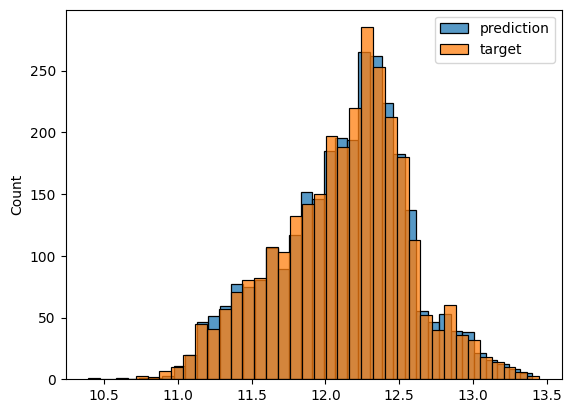

In [276]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.legend()

#### Validate model

In [277]:
# Check the model on validation dataset
y_pred = rf.predict(X_val)

In [278]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.08020939008420074)

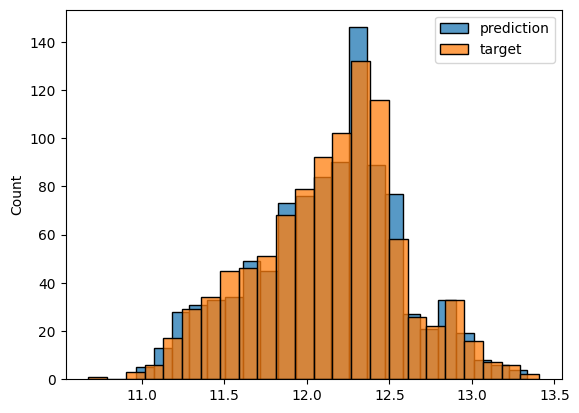

In [279]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='target')
plt.legend()

#### Use model

In [280]:
# Select a house
house = df_test.iloc[120]

# Create dictionary for selected house
house_dict = house.to_dict()

# Create feature matrix for selected house
X_house = dv.transform(house_dict)

In [281]:
house_dict

{'land_size_sqm': 219.0,
 'house_size_sqm': 210.0,
 'no_of_rooms': 3.0,
 'no_of_bathrooms': 4.0,
 'large_living_room': 1.0,
 'parking_space': 1.0,
 'front_garden': 1.0,
 'swimming_pool': 0.0,
 'distance_to_school': 3.5,
 'wall_fence': 0.0,
 'house_age': 4.0,
 'water_front': 0.0,
 'distance_to_supermarket': 3.8,
 'crime_rate_index': 4.72,
 'room_size': 2.0}

In [282]:
# Predict price with Linear Regression model
y_house_pred = np.expm1(lr.predict(X_house))
y_house_pred

array([142757.18847271])

In [283]:
# Predict price with Decision Tree
y_house_pred = np.expm1(dt.predict(X_house))
y_house_pred

array([119534.08309882])

In [284]:
# Predict price with Linear Regression model
y_house_pred = np.expm1(rf.predict(X_house))
y_house_pred

array([144749.10736934])

In [294]:
my_house_dict = {
 'land_size_sqm': 462.0,
 'house_size_sqm': 424.0,
 'no_of_rooms': 6.0,
 'no_of_bathrooms': 4.0,
 'large_living_room': 1.0,
 'parking_space': 1.0,
 'front_garden': 1.0,
 'swimming_pool': 1.0,
 'distance_to_school': 5.1,
 'wall_fence': 1.0,
 'house_age': 16.0,
 'water_front': 0.0,
 'distance_to_supermarket': 5.2,
 'crime_rate_index': 1.81,
 'room_size': 2.0
 }

In [295]:
my_X_house = dv.transform(my_house_dict)

In [296]:
my_y_house_pred = np.expm1(rf.predict(my_X_house))

In [297]:
my_y_house_pred

array([376932.82610222])